# Load Data from Drive

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import glob
import shutil
import os
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch import nn

In [3]:
#@title Load data from drive
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/Amortized Optimal Transport/Data/sinkhorn_bank.zip'
local_path = '/content/sinkhorn_data'
if not os.path.exists(local_path):
  shutil.copy(data_path, '/content/sinkhorn_bank.zip')
  !unzip -q /content/sinkhorn_bank.zip -d {local_path}
  print("Done")
else:
  print("Sinkhorn Data already stored locally")


images_path = '/content/drive/MyDrive/Amortized Optimal Transport/Data/images.zip'
if not os.path.exists('/content/images'):
  shutil.copy(images_path, '/content/images.zip')
  !unzip -q /content/images.zip -d '/content/images'


palettes_path = '/content/drive/MyDrive/Amortized Optimal Transport/Data/palettes.zip'
if not os.path.exists('/content/palettes'):
  shutil.copy(palettes_path, '/content/palettes.zip')
  !unzip -q /content/palettes.zip -d '/content/palettes'

model_state_path = '/content/drive/MyDrive/Amortized Optimal Transport/model_state_dict_k_128.pt'
if not os.path.exists('/content/model_state.pt'):
  shutil.copy(model_state_path, '/content/model_state.pt')

Mounted at /content/drive
Done


In [4]:
sinkhorn_data = torch.load(os.path.join(local_path, 'sinkhorn_bank.pt'))
X_src_indices = sinkhorn_data['X_src_indices']
X_tgt_indices = sinkhorn_data['X_tgt_indices']
y_transport_matrices = sinkhorn_data['y_transport_matrices']

In [5]:
palette_dict = torch.load('/content/palettes/palette_bank.pt')
centroids_tensor = palette_dict['centroids']
weights_tensor = palette_dict['weights']
pixel_cluster_memberships = palette_dict['memberships']
filenames = palette_dict['filenames']

# filename_to_memberships = {filename: pixel_cluster_memberships[i] for i, filename in enumerate(filenames)} # never actually needed

# Training

Data available:
*   X_src_indices
*   X_tgt_indices
*   y_transport_matrices
*   centroids_tensor
*   weights_tensor

Extra:
*   pixel_cluster_memberships
*   filenames
*   filename_to_memberships

In [40]:
#@title Train/Val/Test Split

# We use a 80/10/10 split
X_src_data = torch.cat((centroids_tensor, weights_tensor.unsqueeze(2)), dim=2)[X_src_indices]
X_tgt_data = torch.cat((centroids_tensor, weights_tensor.unsqueeze(2)), dim=2)[X_tgt_indices]
# y_transport_matrices already contains data
print(X_src_data.shape)

X_src_train, X_src_temp, X_tgt_train, X_tgt_temp, y_train, y_temp = train_test_split(
    X_src_data, X_tgt_data, y_transport_matrices, test_size=.2, random_state=67
)

X_src_val, X_src_test, X_tgt_val, X_tgt_test, y_val, y_test = train_test_split(
    X_src_temp, X_tgt_temp, y_temp, test_size=.5, random_state=67
)

print(f"Train: {len(y_train)}, Val: {len(y_val)}, Test: {len(y_test)}")

train_dataset = TensorDataset(X_src_train, X_tgt_train, y_train)
val_dataset = TensorDataset(X_src_val, X_tgt_val, y_val)
test_dataset = TensorDataset(X_src_test, X_tgt_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=4096, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False) #batch size small so that we can better test sinkhorn warm start convergence
test_dataloader = DataLoader(test_dataset, batch_size=4096, shuffle=False)

torch.Size([100000, 128, 4])
Train: 80000, Val: 10000, Test: 10000


In [7]:
#@title NN class and train_epoch
class AmortizerNeuralNetwork(nn.Module):
  def __init__(self, hidden_dim=256):
    super().__init__()
    # input data expected to come with [L, a, b, mass] points (centroid and weight)
    # made encoders deeper and wider (256 dim) to better approximate transport cost (warm start was weak with only one GELU layer and hidden_dim=128)
    self.source_enc = nn.Sequential(
        nn.Linear(4, hidden_dim),
        nn.GELU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.GELU(),
        nn.Linear(hidden_dim, hidden_dim)
    )
    self.target_enc = nn.Sequential(
        nn.Linear(4, hidden_dim),
        nn.GELU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.GELU(),
        nn.Linear(hidden_dim, hidden_dim)
    )
    self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)

  def forward(self, src, tgt):
    queries = self.source_enc(src)
    keys = self.target_enc(tgt)

    #cross attention
    attn_output, attn_weights = self.attention(queries, keys, keys) # same as self.attention.forward(...)
    return attn_weights


def train_epoch(model, train_dloader, optimizer):
  model.train()
  total_loss = 0
  criterion = nn.KLDivLoss(reduction='batchmean')

  # P is the transport matrix
  for batch_idx, (src, tgt, P) in enumerate(train_dloader):
    src = src.to('cuda')
    tgt = tgt.to('cuda')
    P = P.to('cuda')

    # normalize P row sums so that rows sum to 1 to match P_pred scale
    # because model predicts P_pred with row sums each = 1
    P /= P.sum(dim=2, keepdim=True) + 1e-8

    optimizer.zero_grad()

    P_pred = model(src, tgt)
    P_pred_log_probs = torch.log(P_pred + 1e-8)
    loss = criterion(P_pred_log_probs, P)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(train_dloader)

In [8]:
# Training

def train_model(save_state_to_drive=True):
  from IPython.display import clear_output

  model = AmortizerNeuralNetwork().to('cuda')
  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

  loss_history = []

  for epoch in range(100): # Increased epochs slightly to see convergence
    avg_loss = train_epoch(model, train_dataloader, optimizer)
    loss_history.append(avg_loss)

    # Plotting
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, marker='o')
    plt.title(f'Training Loss (Epoch {epoch})')
    plt.xlabel('Epoch')
    plt.ylabel('KL Divergence Loss')
    plt.grid(True)
    plt.show()

    print(f"Epoch {epoch}\t\t avg_loss: {avg_loss:.6f}")

  if save_state_to_drive:
    torch.save(model.state_dict(), '/content/model_state_dict_k_128.pt')
    shutil.copy('/content/model_state_dict_k_128.pt', '/content/drive/MyDrive/Amortized Optimal Transport/model_state_dict_k_128.pt')
  return model

def load_model():
  model = AmortizerNeuralNetwork().to('cuda')
  state = torch.load('/content/model_state.pt')
  model.load_state_dict(state)
  return model

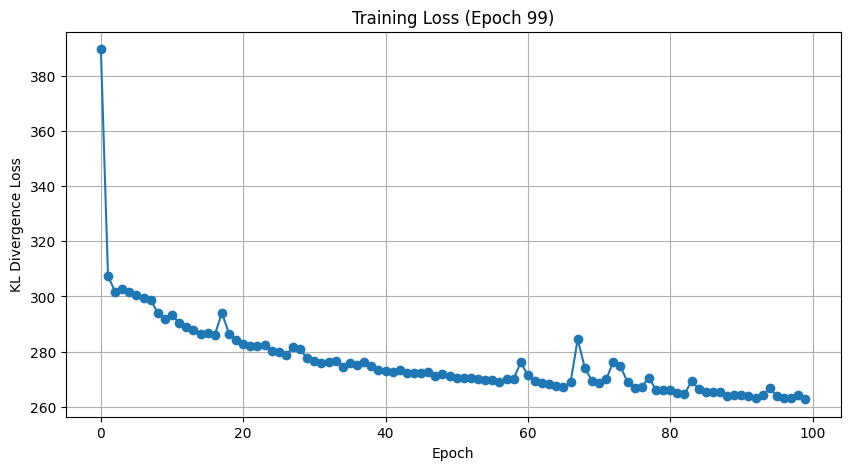

Epoch 99		 avg_loss: 262.784471


In [45]:
model = train_model()
# model = load_model()
# model.eval()

# Sinkhorn Functions

In [10]:
#@title sinkhorn(a, b, cost_matrix, epsilon=.1, max_iters=20000, initial_guess=None)
def sinkhorn(a, b, cost_matrix, epsilon=.1, max_iters=20000, initial_guess=None):
  '''
  My sinkhorn implementation.
  Uses log probabilities to avoid underflow.

  Parameters:
    a: (n,) left/source probability vector
    b: (m,) right/target probability vector
    cost_matrix: (n,m) cost matrix in euclidian space
    epsilon: smoothing parameter for the gibbs kernel

  Returns:
    (n,m) matrix depicting the optimal transport matrix from a to b
  '''
  M = cost_matrix # just renaming
  logK = -M/epsilon
  if initial_guess is not None:
    P0 = initial_guess.clamp_min(1e-12) # avoid log(0)
    logR = torch.log(P0) - logK # approx logu[:,None] + log_v[None,:]
    log_v = torch.zeros(logR.shape[1]).to('cuda')
    for _ in range(10):
      log_u = (logR - log_v.unsqueeze(0)).mean(dim=1)
      log_v = (logR - log_u.unsqueeze(1)).mean(dim=0)
  else:
    log_v = torch.zeros_like(b)

  past_log_v = log_v
  log_a = torch.log(a)
  log_b = torch.log(b)
  log_eps = torch.log(torch.tensor(epsilon))

  iters_done = max_iters
  for i in range(max_iters):
    log_u = log_a - torch.logsumexp(logK + log_v, 1)
    log_v = log_b - torch.logsumexp(logK.T + log_u, 1)

    if torch.allclose(log_v, past_log_v, atol=1e-4, rtol=0):
      iters_done = i
      break

    past_log_v = log_v

  return torch.exp(log_u[:, None] - M / epsilon + log_v[None, :]), iters_done

In [11]:
#@title sinkhorn_batch(a, b, cost_matrix, epsilon=.1, max_iters=20000, initial_guess=None)
def sinkhorn_batch(a, b, cost_matrix, epsilon=.1, max_iters=20000, initial_guess=None):
  '''
  My sinkhorn implementation (handles batches)
  Uses log probabilities to avoid underflow.

  Parameters:
    a: (n,) left/source probability vector
    b: (m,) right/target probability vector
    cost_matrix: (n,m) cost matrix in euclidian space
    epsilon: smoothing parameter for the gibbs kernel

  Returns:
    (n,m) matrix depicting the optimal transport matrix from a to b
  '''
  M = cost_matrix # just renaming
  logK = -M/epsilon
  logK_T = logK.permute(0, 2, 1)
  if initial_guess is not None:
    P0 = initial_guess.clamp_min(1e-12) # avoid log(0)
    logR = torch.log(P0) - logK # approx logu[:,None] + log_v[None,:]
    log_v = torch.zeros(logR.shape[2]).to('cuda')
    for _ in range(10):
      log_u = (logR - log_v.unsqueeze(1)).mean(dim=2)
      log_v = (logR - log_u.unsqueeze(2)).mean(dim=1)
  else:
    log_v = torch.zeros_like(b)

  past_log_v = log_v
  log_a = torch.log(a)
  log_b = torch.log(b)
  log_eps = torch.log(torch.tensor(epsilon))

  iters_done = max_iters
  for i in range(max_iters):
    log_u = log_a - torch.logsumexp(logK + log_v.unsqueeze(1), 2)
    log_v = log_b - torch.logsumexp(logK_T + log_u.unsqueeze(1), 2)

    if torch.allclose(log_v, past_log_v, atol=1e-4, rtol=0):
      iters_done = i
      break

    past_log_v = log_v

  return torch.exp(log_u[:, :, None] - M / epsilon + log_v[:, None, :]), iters_done

# Saving Data for Validation
NOTE: thorough fine-tuning of sinkhorn epsilon, sinkhorn atol, k of kmeans, kmeans tolerance, source_enc and target_enc layers in the NN, hidden_dim in NN, and other parameters was too expensive for the scale of this project, hence validation was largely omitted.

In [33]:
#@title get_marginal_error(P_pred_batch, source_weights_batch, target_weights_batch) and validate(model, val_dloader)
def get_marginal_error(P_pred_batch, source_weights_batch, target_weights_batch):
  '''
  Caluclates the sum error betweem the column sums of P_pred and the target_weights

  Parameters:
    P_pred_batch: (batch, k, k) transport matrices
    source_weights_batch: (batch, k) source weight vectors
    target_weights_batch: (batch, k) target weight vectors
  Returns:
    mean of mariginal errors across batch
  '''
  C_mapped = P_pred_batch.permute(0, 2, 1) @ source_weights_batch.unsqueeze(2)
  return torch.abs(C_mapped.squeeze(2) - target_weights_batch).sum(dim=1).mean()

def validate(model, val_dloader):
  '''
  Parameters:
    model: trained neural network
    val_dloader: DataLoader with validation data loaded
  Returns:
    avg_kl_loss: average KL divergence across dloader data
    avg_marginal_error: average marginal error between predicted and true matrix in val data
  '''
  model.eval()
  total_kl_loss = 0
  total_marginal_error = 0
  criterion = nn.KLDivLoss(reduction='batchmean')

  with torch.no_grad():
    for batch_idx, (src, tgt, P) in enumerate(val_dloader):
      src = src.to('cuda')
      tgt = tgt.to('cuda')
      P = P.to('cuda')
      P /= P.sum(dim=2, keepdim=True) + 1e-8

      P_pred = model(src, tgt)
      loss = criterion(torch.log(P_pred + 1e-8), P)
      total_kl_loss += loss.item()

      marginal_error = get_marginal_error(P_pred, src[:, :, 3], tgt[:, :, 3])
      total_marginal_error += marginal_error

  avg_kl_loss = total_kl_loss / len(val_dloader)
  avg_marginal_error = total_marginal_error / len(val_dloader)
  return avg_kl_loss, avg_marginal_error

In [34]:
val_kl_loss, val_marginal_error = validate(model, val_dataloader)
print(f"Validation average KL Loss: {val_kl_loss}")
print(f"Validation average Marginal Error: {val_marginal_error}")

# Validation average KL Loss: 264.4243993302123
# Validation average Marginal Error: 0.5262816548347473

Validation average KL Loss: 264.4243993302123
Validation average Marginal Error: 0.5262816548347473


In [36]:
def validate_sinkhorn_iteration_count(model, val_dataloader, use_warm_start=True):
  '''
  Returns:
    list of number of iterations per batch
  '''
  model.eval()

  # stores max per batch. kept val_dataloader batch sizes small (8) so that this is still telling
  all_iters = []

  with torch.no_grad():
    for src, tgt, P in tqdm(val_dataloader):
      src, tgt = src.to('cuda'), tgt.to('cuda')
      src_weights = src[:, :, 3]
      tgt_weights = tgt[:, :, 3]

      P_pred = model(src, tgt)
      P0 = P_pred * src_weights.unsqueeze(2)

      sinkhorn_iters_needed = 0
      init_guess = src_weights.unsqueeze(1) * P_pred
      P_pred, sinkhorn_iters_needed = sinkhorn_batch(src_weights, tgt_weights, torch.cdist(src[:, :, :3], tgt[:, :, :3]), initial_guess=init_guess if use_warm_start else None)
      new_centroids = P_pred @ tgt[:, :, :3] / src_weights.unsqueeze(2)

      all_iters.append(sinkhorn_iters_needed)

  return all_iters

In [41]:
warm_iters = validate_sinkhorn_ikhorn_iteration_count(model, val_dataloader, use_warm_start=True)
cold_iters = validate_sinteration_count(model, val_dataloader, use_warm_start=False)

100%|██████████| 1250/1250 [26:46<00:00,  1.29s/it]


In [42]:
def avg_max_90ptcl(all_iters):
  return sum(all_iters) / len(all_iters), max(all_iters), np.percentile(all_iters, 90)[0]
print(avg_max_90ptcl(warm_iters))
print(avg_max_90ptcl(cold_iters))

# (3583.9168, 20000, 5890.200000000001)
# (3627.0232, 20000, 6019.600000000005)

(3583.9168, 20000, np.float64(5890.200000000001))
(3627.0232, 20000, np.float64(6019.600000000005))


In [43]:
if not os.path.exists('/content/validation_iters/'):
  !mkdir '/content/validation_iters'
torch.save(warm_iters, '/content/validation_iters/warm_iters.pt')
torch.save(cold_iters, '/content/validation_iters/cold_iters.pt')
archive_path = shutil.make_archive(base_name=f'/content/validation_iters', format='zip', root_dir='/content/validation_iters')
shutil.copy('/content/validation_iters.zip', '/content/drive/MyDrive/Amortized Optimal Transport/Data/validation_iters')

'/content/drive/MyDrive/Amortized Optimal Transport/Data/validation_iters'

# Testing

In [44]:
test_kl_loss, test_marginal_error = validate(model, test_dataloader)
print(f"Test average KL Loss: {val_kl_loss}")
print(f"Test average Marginal Error: {val_marginal_error}")

# Testing average KL Loss: 264.4243993302123
# Testing average Marginal Error: 0.5262816548347473

Validation average KL Loss: 264.4243993302123
Validation average Marginal Error: 0.5262816548347473
